## Problem Statement: Identify the driving factors (or driver variables) behind loan default. These are variables which are strong indicators of default.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('loan.csv', low_memory=False)

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


### Data Cleaning

#### Are there columns which contains only null values, if yes, such columns can be dropped.

In [4]:
# Drop the columns which are null.
for column_name in df.columns:
    # Finding columns where all the values are null.
    if df[column_name].isnull().sum() == df.shape[0]:
        # drop the columns which doesn't contain any values.
        df.drop(column_name, axis=1, inplace=True)

In [5]:
# Check the shape of updated df.
df.shape

(39717, 57)

In [6]:
#checking df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

#### Identify columns where all non null values are same. No real insight can be found from those column.

In [7]:
# creating column sub set to identify data
columns_subset = ['id','loan_amnt', 'issue_d', 'revol_util', 'funded_amnt', 'total_pymnt', 'term', 'int_rate', 'installment', 
                    'grade', 'loan_status', 'verification_status', 'pub_rec']

#### Drop all columns which contain same value or null for all rows. As they won't give any useful insights

In [8]:
df = df.loc[:, df.nunique() > 1]

#### Missing value imputation.

In [9]:
# Identify columns with missing values.
print(df.columns[df.isnull().any()])

Index(['emp_title', 'emp_length', 'desc', 'title', 'mths_since_last_delinq',
       'mths_since_last_record', 'revol_util', 'last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d', 'pub_rec_bankruptcies'],
      dtype='object')


In [10]:
# There are 2459 borrower who didn't supply their job title/company name. In this case, missing fields can be marked as UNKNOWN
df.emp_title = df.emp_title.fillna('Unknown')

In [11]:
# Analysising emp_length
df.emp_length.value_counts()

# Filling null values in emp_length with Unknown as well.
df.emp_length = df.emp_length.fillna('Unknown')

In [12]:
# Analyzing desc
df[df.desc.isnull()]

# found 12942 rows where desc is null.
# replacing all with unknown.
df.desc = df.desc.fillna('Unknown')

In [13]:
# Analyzing title
# This is a title provided by the borrower, Filling null values with 'Missing'
# df[df.title.isnull()]
# df.title.value_counts()
df.title = df.title.fillna('Missing')

In [14]:
# Analyzing mths_since_last_delinq
df.mths_since_last_delinq.info()

# There is significant number (25682) of borrowers without delinquency info. Lets the the rows.
df[df.mths_since_last_delinq.isnull()]

# It looks like borrowers without doesn't have an history of delinquency.
# Filling null with -1 for all borrowers where mths_since_last_delinq is null.
df.mths_since_last_delinq = df.mths_since_last_delinq.fillna(-1)

<class 'pandas.core.series.Series'>
RangeIndex: 39717 entries, 0 to 39716
Series name: mths_since_last_delinq
Non-Null Count  Dtype  
--------------  -----  
14035 non-null  float64
dtypes: float64(1)
memory usage: 310.4 KB


In [15]:
# Analyzing revol_util
# This field specifies the balance that carries over from one month to the next is the revolving balance on that loan.

# How many fileds doesn't contain revol_util
df[df.revol_util.isnull()].shape  #50

# What is the loan status on these accounts
df[df.revol_util.isnull()].loan_status.value_counts() # Fully Paid: 34, Charged off: 16

# Result: Out of all the rows where revol_util is null, loan status is either Fully Paid or Charged off.
# We can set the null values with -1 placeholder
df.revol_util = df.revol_util.fillna(-1)

# Format the fields.
df.revol_util = df.revol_util.apply(lambda x: x.replace('%', '') if x != -1 else x)
df.revol_util = df.revol_util.astype(float)

In [16]:
# Analyzing last_pymnt_d
# This is the month when last payment was received.
df[df.last_pymnt_d.isnull()] # There are total 71 such accounts.

# how many of these are not charged off?
df[(df.last_pymnt_d.isnull()) & (df.loan_status != 'Charged Off')][columns_subset]   # 0
# Summary: All the rows without last_pymnt_d are Charged Off.

# Filling all such rows as with temp values will end up corrupting the data. dropping all such rows.
df = df[~(df.last_pymnt_d.isnull())]

In [17]:
# Analyzing next_pymnt_d
df[df.next_pymnt_d.isnull()] # There are no such rows remaining

df[(df.next_pymnt_d.isnull()) & (df.loan_status == 'Current')][columns_subset]
# Next payment date for all active loans are present.

,id,loan_amnt,issue_d,revol_util,funded_amnt,total_pymnt,term,int_rate,installment,grade,loan_status,verification_status,pub_rec


In [18]:
# Analyzing last_credit_pull_d
df[df.last_credit_pull_d.isnull()][columns_subset]
# There or 2 such rows, one is Charged off where as another on is Fully Paid.
# This could be data corruption issue, removing these two rows.

df = df[~df.last_credit_pull_d.isnull()]

In [19]:
pd.options.mode.copy_on_write = True

In [20]:
# Analyzing pub_rec_bankruptcies
df[df.pub_rec_bankruptcies.isnull()][columns_subset] #696

# how many borrowers have public records but not public bankruptcy record
df[(df.pub_rec_bankruptcies.isnull()) & (df.pub_rec != 0)][columns_subset].shape #20


# Bankruptcy records may or may not be available for everyone. If someone does't have Bankruptcy record,
# it is safe to assume they are not Bankrupt. Imputing null values with median
bankruptcies_median = df.pub_rec_bankruptcies.median()
df['pub_rec_bankruptcies'] = df.pub_rec_bankruptcies.fillna(bankruptcies_median)


#### Data Clean-up: Formatting values

In [21]:
# Removing % from int_rate.
df.int_rate = df.int_rate.apply(lambda x: x.replace('%', ''))
df.int_rate = df.int_rate.astype(float)

#### Data Clean-up: Creating New Segments

In [22]:
# Create new segment for earliest credit line year.
df.earliest_cr_line.value_counts()
df['earliest_cr_line_year'] = pd.to_datetime(df.earliest_cr_line, format='%b-%y').dt.year

# Create new segment for loan issue year and loan issue month
df['issue_month'] = pd.to_datetime(df.issue_d, format='%b-%y').dt.month
df['issue_year'] = pd.to_datetime(df.issue_d, format='%b-%y').dt.year

In [23]:
# Segmenting Interest Rate
df['int_rate_cat'] = pd.qcut(df.int_rate, [0, 0.2, 0.4, 0.6, 0.8, 1], ['VL', 'L', 'M', 'H', 'VH'])
df[['int_rate', 'int_rate_cat']].head(20)

,int_rate,int_rate_cat
0,10.65,L
1,15.27,H
2,15.96,VH
3,13.49,H
4,12.69,M
5,7.90,VL
6,15.96,VH
7,18.64,VH
8,21.28,VH
9,12.69,M


In [24]:
# Segmenting Loan Amount
df['loan_amnt_cat'] = pd.qcut(df.int_rate, [0, 0.2, 0.4, 0.6, 0.8, 1], ['VL', 'L', 'M', 'H', 'VH'])
df[['loan_amnt', 'loan_amnt_cat']].head()

,loan_amnt,loan_amnt_cat
0,5000,L
1,2500,H
2,2400,VH
3,10000,H
4,3000,M


In [25]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies,earliest_cr_line_year,issue_month,issue_year,int_rate_cat,loan_amnt_cat
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,Jan-15,171.62,NaN,May-16,0.0,1985,12,2011,L,L
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,Apr-13,119.66,NaN,Sep-13,0.0,1999,12,2011,H,H
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,Jun-14,649.91,NaN,May-16,0.0,2001,12,2011,VH,VH
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,Jan-15,357.48,NaN,Apr-16,0.0,1996,12,2011,H,H
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,May-16,67.79,Jun-16,May-16,0.0,1996,12,2011,M,M


In [26]:
# Create a new columns for defaulted borrowers
df['defaulted'] = df.loan_status.apply(lambda x: 1 if x == 'Charged Off' else 0)

### Outlier Treatment

(35669, 54)

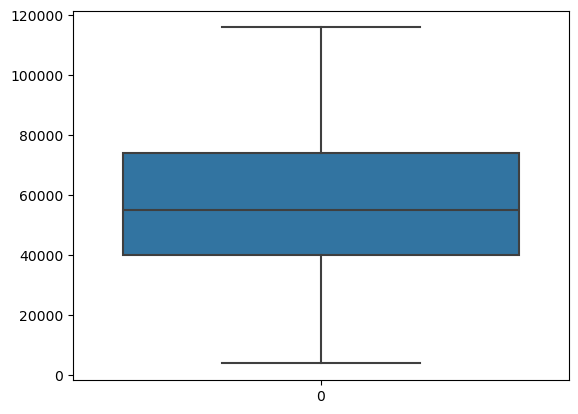

In [27]:
# Annual income
# Here the spread is left leaning. removing outliers.
df = df[df.annual_inc < df.annual_inc.quantile(0.9)]

sns.boxplot(df.annual_inc)
df.shape

### Data Analysis

#### Univariate Analysis

In [28]:
# Plots a count plot for given column.
def _plot_count(column_name, dataframe = df):
    ax = sns.countplot(x=column_name, data=dataframe, palette='Set2')
    # add percentage to the bar
    for p in ax.patches:
        height = p.get_height()
        x = p.get_x() + p.get_width()/2
        percentage = (height/len(dataframe)) * 100
        ax.text(x, height + 0.1, f'{percentage:.2f}%', ha='center', va='bottom')
        
    # Customize the plot
    plt.title(f"{column_name.title()} spread across all Loans", fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel(f"{column_name.title()}", fontsize=12)
    plt.show()

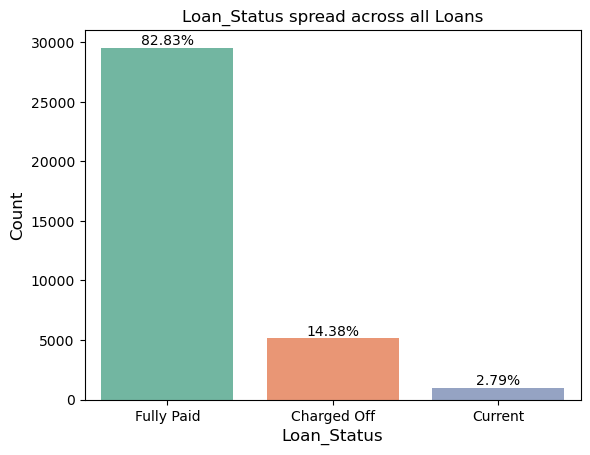

In [29]:
# What is the spread of loan type
_plot_count('loan_status')
# Analysis: Majority of the loans are fully paid. 14.38% are Charged off.

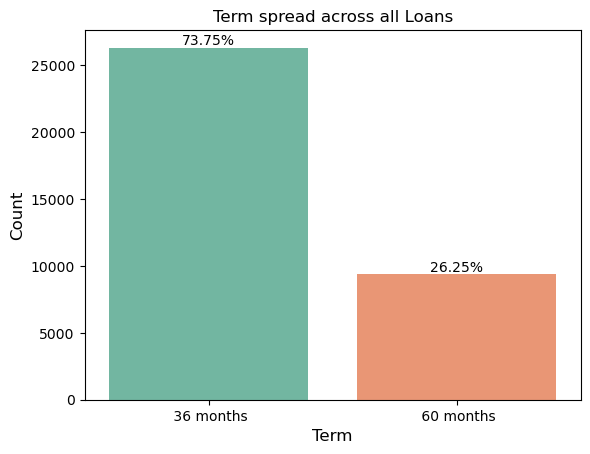

In [30]:
# Loan Term
# How does the loan term look like?
_plot_count('term')
# Analysis: Most of the loan terms are 3years.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


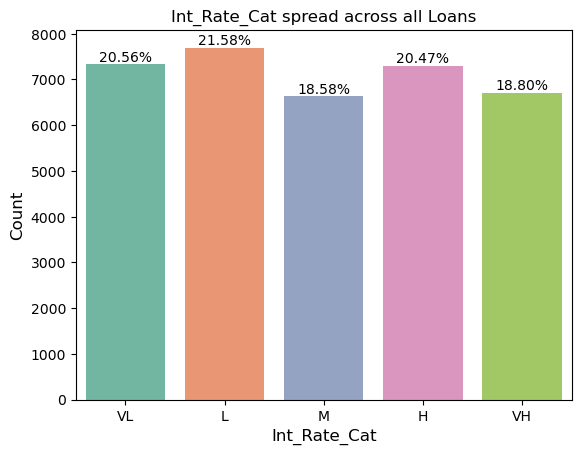

In [31]:
# Interest Rate
# What does the interest rate spread look like?
_plot_count('int_rate_cat')
# Interest rates are somewhat evenly distributed accross all interest ranges.

### Bivariate Analysis

In [32]:
# Plots count plot for given column across all loan status.
def _plot_count_by_category_c(column_name, dataframe = df):
    ax = sns.countplot(x='loan_status', hue=column_name, data=dataframe, palette='Set2')
    # add percentage to the bar
    for p in ax.patches:
        height = p.get_height()
        x = p.get_x() + p.get_width()/2
        percentage = (height/len(dataframe)) * 100
        ax.text(x, height + 0.1, f'{percentage:.2f}%', ha='center', va='bottom')
    
    # Customize the plot
    plt.title(f"{column_name.title()} across Loan status")
    plt.xlabel('Loan Status')
    plt.ylabel(f"Number of {column_name.title()}")
    plt.show()


# Plots the defaulters by count in categorical column column_name
def _plot_bar_of_defaulters_c(column_name, dataframe = df):
    grouped_total = dataframe.groupby(column_name).size()
    grouped_defaulters_count = dataframe[dataframe.defaulted == 1].groupby(column_name).size()
    
    percent = round((grouped_defaulters_count / grouped_total) * 100, 2)
    per_df = percent.reset_index(name='defaulter_pct')
    
    # Drop rows with null defaulter pct.
    per_df = per_df[~per_df['defaulter_pct'].isnull()]

    # bar plot
    ax = sns.barplot(x=column_name, y='defaulter_pct', data=per_df, palette='Set2')

    # Customize the plot
    plt.title(f"Percentage of defaulters in each {column_name.title()}")
    plt.ylabel('% of Defaulters')
    plt.xlabel(column_name.title())
    
    # Add percentage values on the bar.
    for p in ax.patches:
        height = p.get_height()
        x = p.get_x() + p.get_width()/2
        ax.text(x, height + 0.1, f'{height:.2f}%', ha='center', va='bottom')
    plt.show()

# Plots box plot for given column
def _plot_box_n(column_name, dataframe = df):
    # Box plot for 
    sns.boxplot(x='loan_status', y=column_name, data = dataframe, palette='Set2')

    # Customize the plot
    plt.title(f"Spread of {column_name.title()} across different types Loan Status.", fontsize=12)
    plt.ylabel(column_name.title())
    plt.xlabel('Loan Status')
    plt.show()


# Plots line for given numeric column against defaulters across Loan issue year.
def _plot_line_for_defaulters_across_year_n(column_name, dataframe = df):
    avg_of_all_by_year = df.groupby('issue_year')[column_name].mean()
    avg_of_defaulter_by_year = df[df.defaulted == 1].groupby('issue_year')[column_name].mean()
    
    # Line plot for all borrowers
    ax_all = sns.lineplot(x=avg_of_all_by_year.index, y=avg_of_all_by_year.values, label='All Borrowers', linewidth=2)
    ax_all.set_xticks(avg_of_all_by_year.index)
    
    # Line plot for defaulted borrowers
    ax_defaulter = sns.lineplot(x=avg_of_defaulter_by_year.index, y=avg_of_defaulter_by_year.values, label='Defaulted Borrowers', linewidth=2)
    ax_defaulter.set_xticks(avg_of_defaulter_by_year.index)
    
    # Customize the plot
    plt.title(f"{column_name.title()} of Borrowers vs Defaulted Borrowers", fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(f"Average {column_name}", fontsize=12)
    plt.legend(title='Loan Status')
    plt.show()
    


### Running Bivariate Analysis on Borrower Attributes

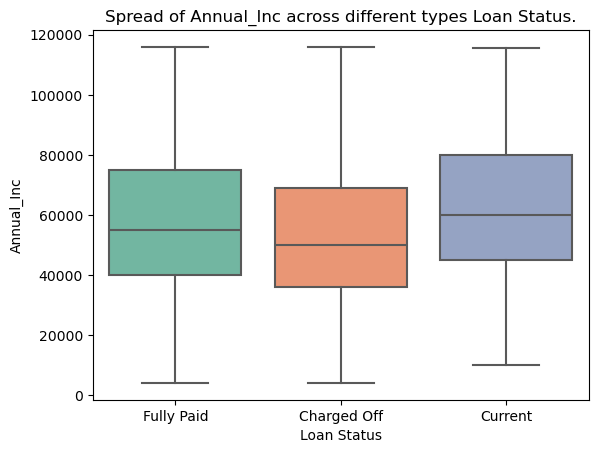

In [33]:
# Annual Income\
_plot_box_n('annual_inc')
# There is slight correlation between annual income and defaulting loan. 
# Average defaulter are have lower annual income than other categories.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

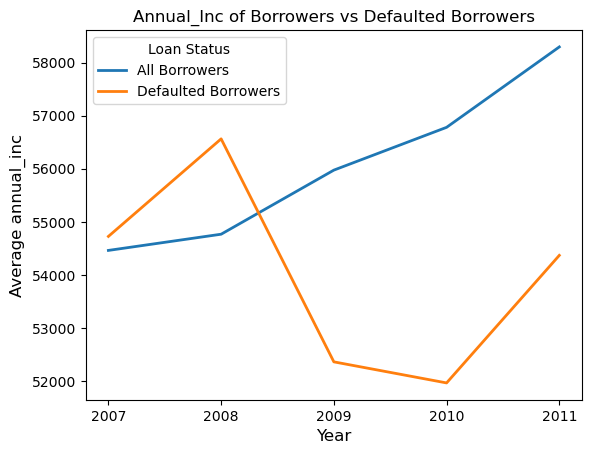

In [34]:
# How does average annual income of all borrowers vs borrowers who defaulted looks like?
_plot_line_for_defaulters_across_year_n('annual_inc')
# Analysis: Average annual income of borrowers who defaulted, seems to be falling in the recent history.

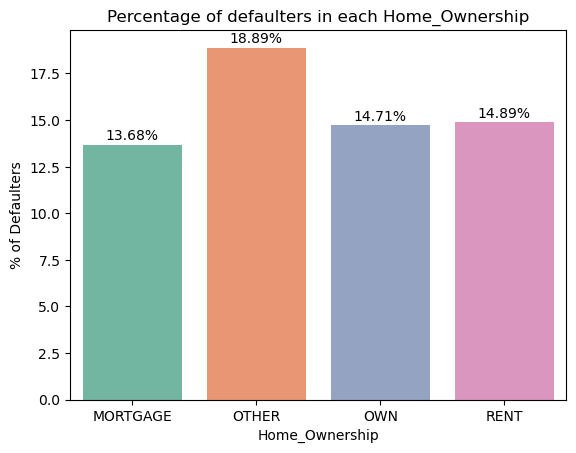

In [35]:
# Home Ownership
_plot_bar_of_defaulters_c('home_ownership')
# Analysis: Borrowers who didn't clearily specify their home ownership status tend to default more than others.

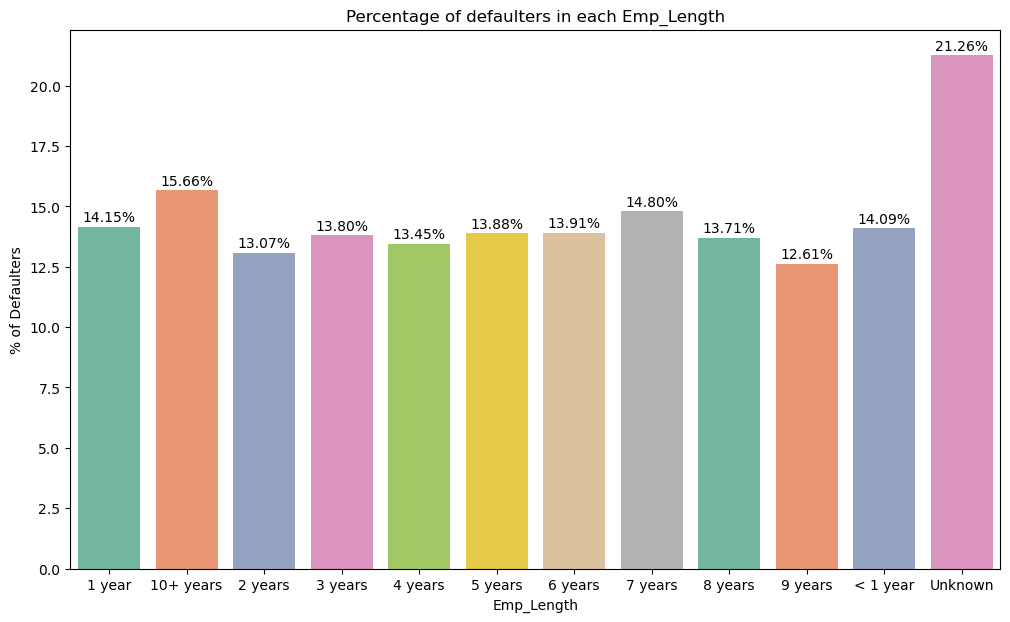

In [36]:
# Employment Length
plt.figure(figsize=(12,7))
_plot_bar_of_defaulters_c('emp_length')
# Analysis: Borrowers without employment lenght information tend to default significantly more than others.

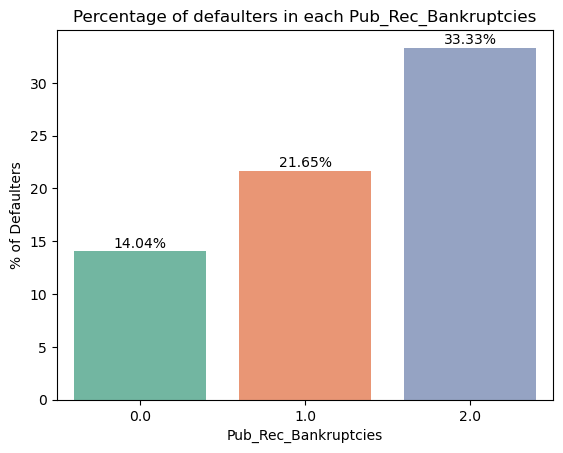

In [37]:
# Number of Bankruptcies
_plot_bar_of_defaulters_c('pub_rec_bankruptcies')
# Analysis: Borrowers with Bankruptcy record tend to default on the their loan signnificantly higher than others. 

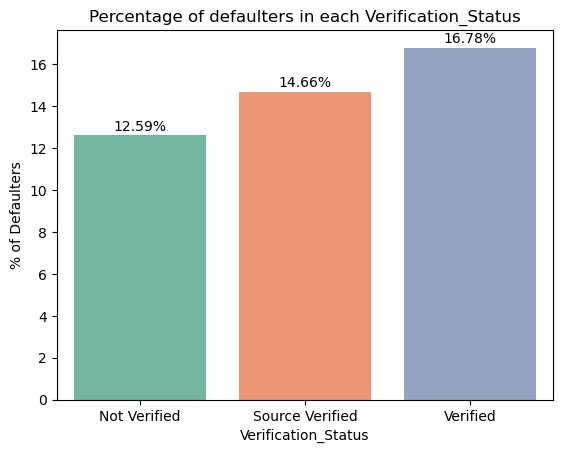

In [38]:
# Verification Status
_plot_bar_of_defaulters_c('verification_status')
# Analysis: This is quite interesting, verified borrowers tend to default slightly more than others.

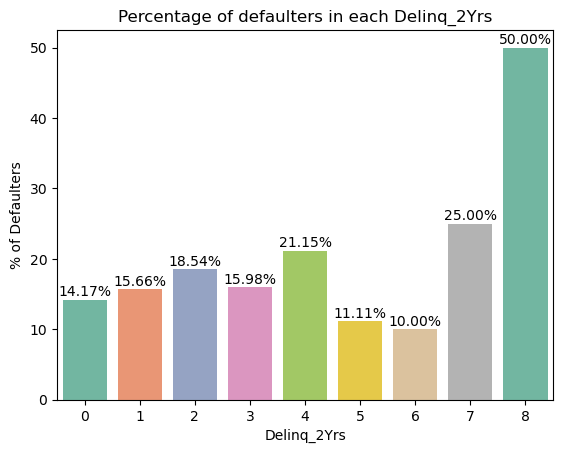

In [39]:
_plot_bar_of_defaulters_c('delinq_2yrs')
# Analysis: There is a strong correlation between the number of delinquency in last 2 year and defaulting loan. 
# Though there is an anomaly in between at delinq count 5 and 6.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

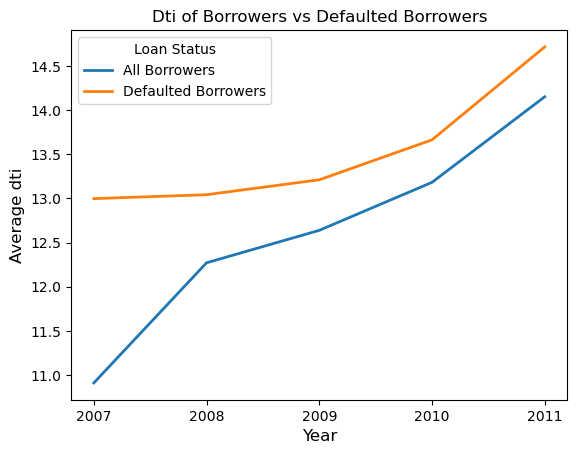

In [40]:
# Debt to income ratio
_plot_line_for_defaulters_across_year_n('dti')
# Debt to income ratio in defaulter is significantly higher than others.

### Running Bivariate Analysis on Loan Attributes

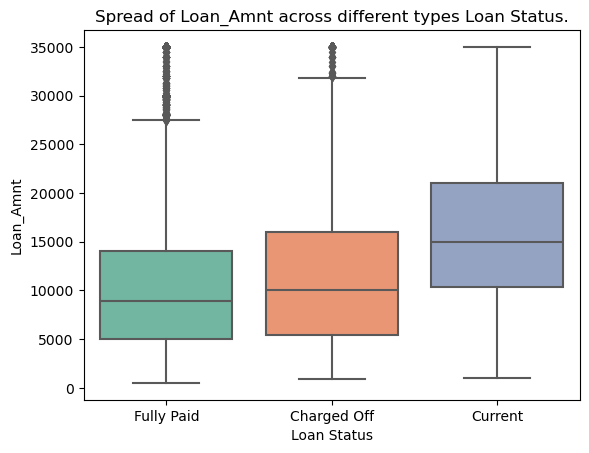

In [41]:
# Loan Amount
_plot_box_n('loan_amnt')
# Analysis: Loans with higher amount tends to default more.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

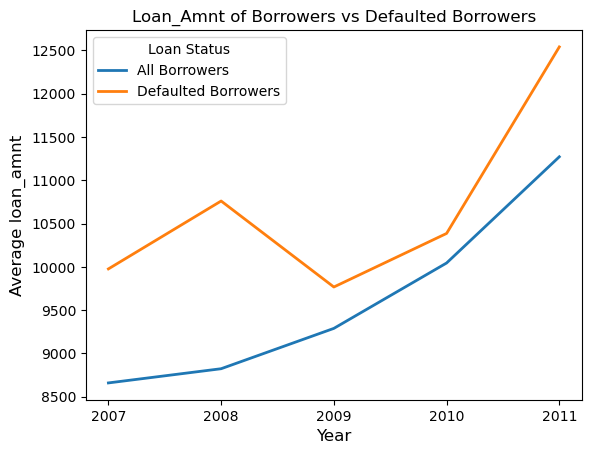

In [42]:
_plot_line_for_defaulters_across_year_n('loan_amnt')

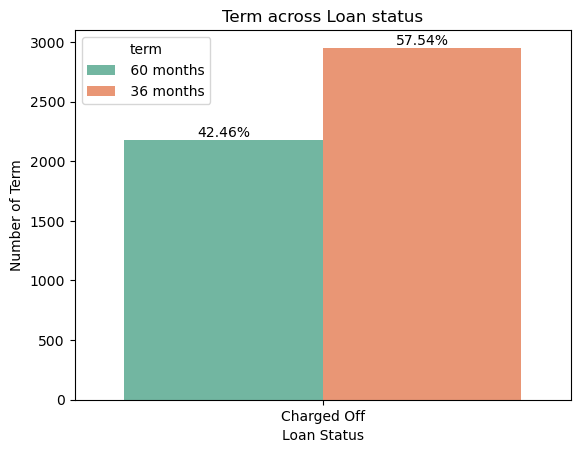

In [43]:
# Loan Term
# As seen about around 75% of the loans have 36 Months tenure but only 58% of the all the charged off loans are charged off.
# Analysis: Loans with 60 Months tenure have a higher chance of defaulting.
_plot_count_by_category_c('term', df[df.loan_status == 'Charged Off'])

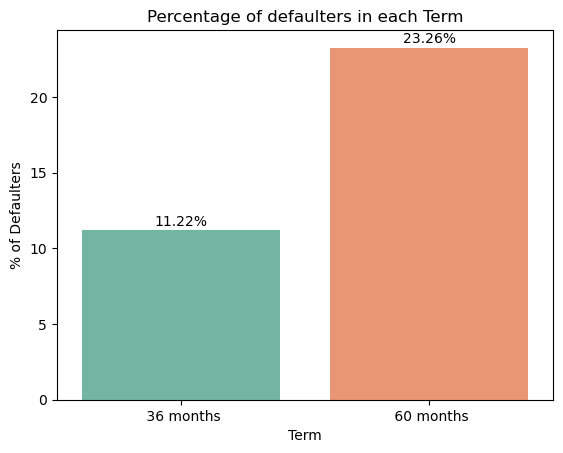

In [44]:
_plot_bar_of_defaulters_c('term')

/var/folders/1k/3qrrh5n144lg22cnq5nt046c0000gr/T/ipykernel_557/2561020186.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_total = dataframe.groupby(column_name).size()
/var/folders/1k/3qrrh5n144lg22cnq5nt046c0000gr/T/ipykernel_557/2561020186.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_defaulters_count = dataframe[dataframe.defaulted == 1].groupby(column_name).size()
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

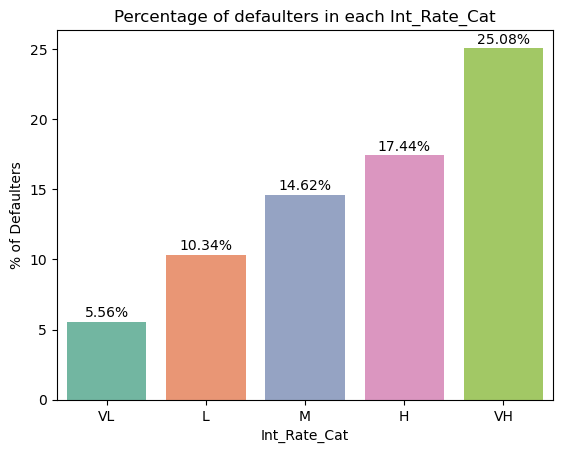

In [45]:
# Interest Rate
_plot_bar_of_defaulters_c ('int_rate_cat')
# The spread is almost comparable across all interest rate ranges, 

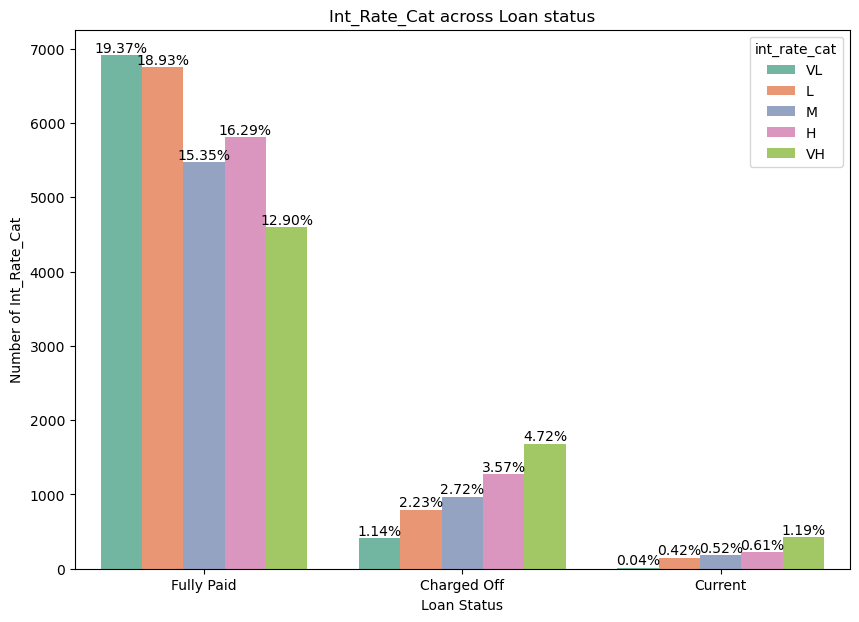

In [46]:
plt.figure(figsize=(10,7))
_plot_count_by_category_c('int_rate_cat')
# Analysis: Loans with higher interest rates tends to default more.

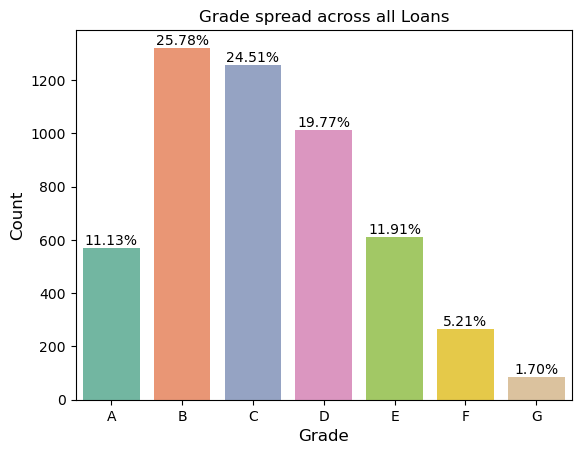

In [47]:
_plot_count('grade', df[df.loan_status == 'Charged Off'].sort_values(by='grade'))
# Analysis: Loans in B, C and D have significantly higher share in defaulters. Does this mean they are they are unsafe?

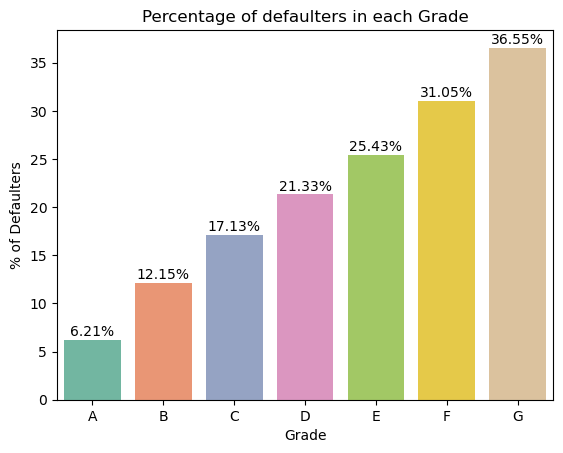

In [48]:
# Lets check what percentage of each grade default out of all the loan application in that grade.
_plot_bar_of_defaulters_c('grade')
# Analysis: From this

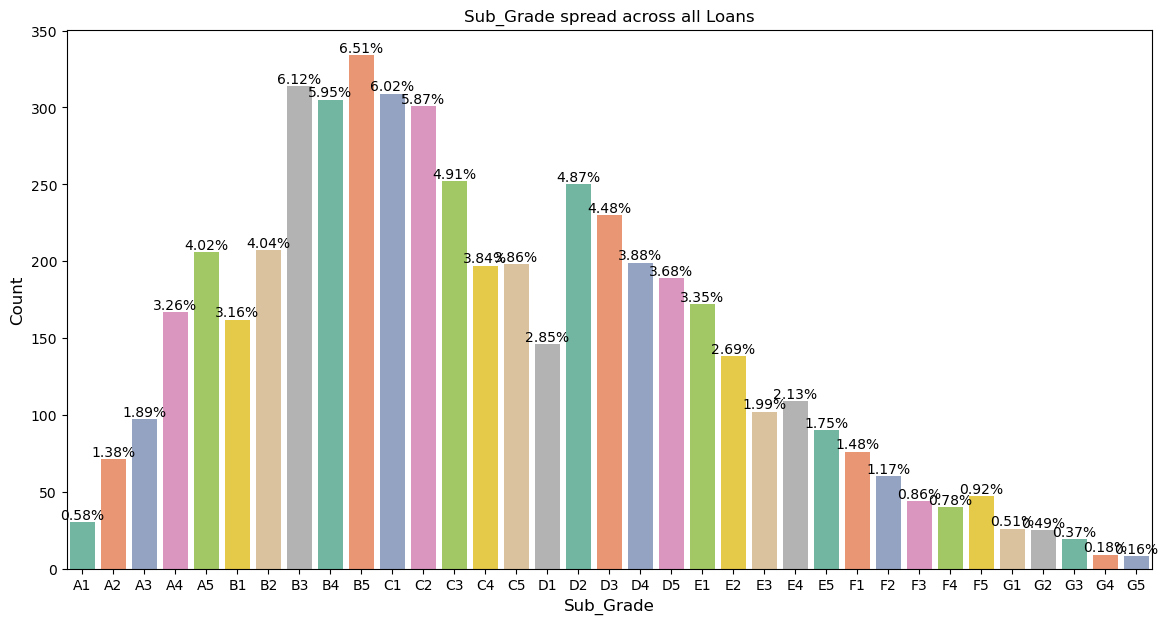

In [49]:
# Sub Grade
plt.figure(figsize=(14,7))
_plot_count('sub_grade', df[df.loan_status == 'Charged Off'].sort_values(by ='sub_grade'))

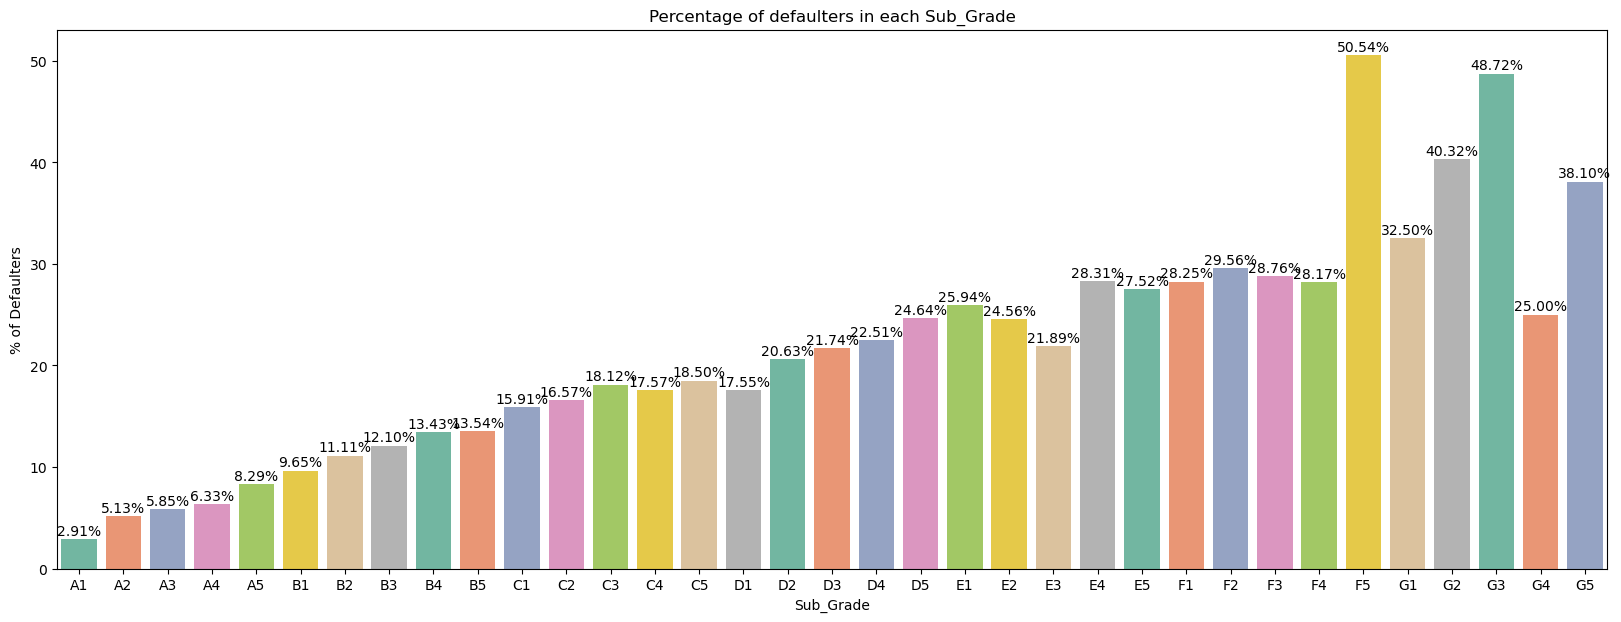

In [50]:
plt.figure(figsize=(20,7))
_plot_bar_of_defaulters_c('sub_grade')

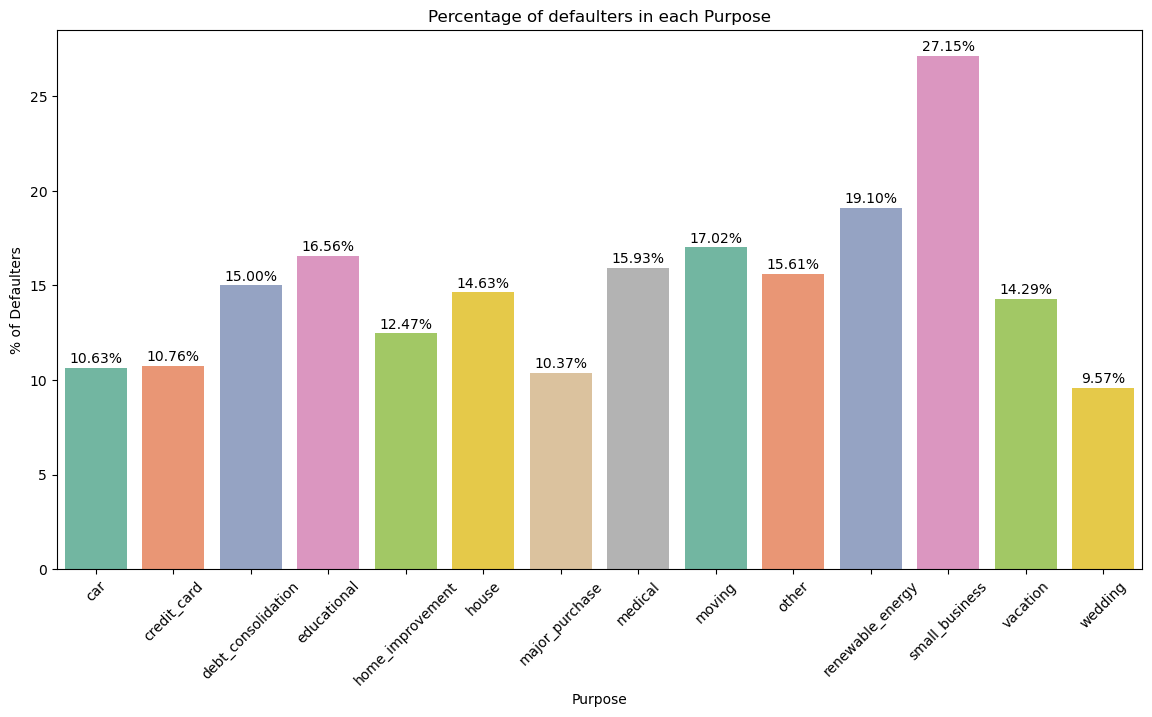

In [51]:
# Purpose
plt.figure(figsize=(14,7))
plt.xticks(rotation=45)
_plot_bar_of_defaulters_c('purpose')
# Analysis: There is a strong correlation between loans taken for small business and defaulting. 
# Loans taken for Wedding, Car, Major Purchase and credit card are relatively safe.